In [1]:
# imports 
from empath import Empath
lexicon = Empath()

## Steps for feature analysis aka violence metric


1. Take advantage of Empath package to obtain categories representatives of violence
    - a. Produce clean data locally thanks to results 
    - b. Preprocess as did in the paper to train Empath to ensure alignment with features found 
    - c. Perform Empath.lexicon.analyse with word counts, sorted_list (gives out cosine similarity between the vector of the category and the vector of the text given (need to reread that in paper))

2. Identify the most represented categories in the plot per genre, per year
3. Identify the most represented categories per movies classified as violent per ChatGPT 
4. Balance the frequencies of the words per their weight //TFID-matrix 
5. Our own logistic regression model : stantardise/normalise the train, test data 
6. Transform our plots in bags of words 
7. Side quest: Perform clustering on bags of words (idea: does it appear by itself group of violent movies)
8. Visualisation of number of words per movies, per genres 
9. If skewed, try logarithm and see if it becomes gaussian -> fit with logarithm 
10. Our own model : have p-value
Idea : try to replicate chatgpt predictions and explain them 

In [33]:
# Manual selection of supposedly violent categories

violent_categories = ["hate", "aggression", "occupation", "crime", "prison", "dispute", "nervousness", "horror", 
              "swearing_terms", "suffering", "kill", "fear", "death", "violence", "dominant_heirarchical", 
              "neglect", "monster", "weapon", "negative_emotion", "pain", "terrorism", "breaking", 
              "disappointment", "anger", "torment", "shame", "emotional", "sadness",
              "rage", "injury", "fire", "disgust", "war", "dominant_personality",
              "fight", "deception",]

# If we want to manually inspect the categories
""" for category in categories: 
    print("Category =" + category, lexicon.cats.get(category)) """

' for category in categories: \n    print("Category =" + category, lexicon.cats.get(category)) '

### Emma's playground (04.12.2024) starts here

In [3]:
# We import the clean dataset (& have a look at it again, just because it's beautiful)
import pandas as pd
Movie_Data = pd.read_csv('../data/CLEAN/Movie_Data_clean.tsv', sep="\t")

Movie_Data

,Wikipedia movie ID,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot
0,975900,Ghosts of Mars,2001-08-24,14010832.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...","set in the second half of the 22nd century, th..."
1,6631279,Little city,1997-04-04,NaN,English Language,United States of America,"Romantic comedy, Ensemble Film, Comedy-drama, ...","adam, a san francisco-based artist who works a..."
2,77856,Mary Poppins,1964-08-27,102272727.0,English Language,United States of America,"Children's/Family, Musical, Fantasy, Comedy, D...",the film opens with mary poppins perched in a...
3,21926710,White on Rice,2009-05-31,NaN,NaN,United States of America,"Romantic comedy, Romance Film, Comedy, Indie",jimmy ([[hiroshi watanabe loves dinosaurs and...
4,156558,Baby Boy,2001-06-27,29381649.0,English Language,United States of America,"Crime Fiction, Drama, Coming of age",a young 20-year-old named jody lives with his...
...,...,...,...,...,...,...,...,...
17072,25011340,Dot.Kill,2005-03-08,NaN,NaN,United States of America,"Thriller, Crime Thriller, Action, Psychologica...","charlie daines , is a morphine-addicted detect..."
17073,7761830,Spaced Invaders,1990-04-27,15369573.0,English Language,United States of America,"Alien Film, Science Fiction, Family Film, Come...","the space armada from mars, known as the imper..."
17074,1918494,State and Main,2000-08-26,6944471.0,"Italian Language, English Language","France, United States of America","Parody, Americana, Comedy",havoc is wrought on the inhabitants of a small...
17075,664006,Guilty as Sin,1993-06-04,22886222.0,NaN,United States of America,"Thriller, Erotic thriller, Psychological thril...",jennifer haines is an up-and-coming chicago a...


In [4]:
# Let's try this all with the first summary

Plot_test = Movie_Data.loc[0]["Plot"]

# Now, let's use spacy, to tokenize
import spacy

nlp = spacy.load('en_core_web_sm') # requires python spacy download en !
doc = nlp(Plot_test)
Plot_tokens = [token.text for token in doc]

print(Plot_test,'\n')
print(Plot_tokens)

set in the second half of the 22nd century, the film depicts mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. the martian society has become largely matriarchal, with women in most positions of authority. the story concerns a police officer, melanie ballard , second in command of a small team alongside sergeant jericho  sent to pick up and transport a prisoner named desolation williams . arriving at the remote mining town where williams is being held, ballard finds virtually all of the people missing. she learns that the miners had discovered an underground doorway created by an ancient martian civilization. when the door was opened it released "ghosts," disembodied spirits which possessed the miners. violence ensues, as the possessed miners commit horrific acts of death and destruction, as well as self-mutilation. with their team leader helena bradock  murdered, ballard must fight off the attacking miners, escape th

In [6]:
# Now let's detect the stopwords

spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))
print('First ten stop words:',list(spacy_stopwords)[:10])

Number of stop words: 326
First ten stop words: ['’s', 'get', 'seems', 'anyhow', 'towards', 'unless', 'twenty', 'once', 'did', 'few']


In [7]:
print(Plot_test,'\n')
stop_words = [token.text for token in doc if token.is_stop]
print(stop_words)

set in the second half of the 22nd century, the film depicts mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. the martian society has become largely matriarchal, with women in most positions of authority. the story concerns a police officer, melanie ballard , second in command of a small team alongside sergeant jericho  sent to pick up and transport a prisoner named desolation williams . arriving at the remote mining town where williams is being held, ballard finds virtually all of the people missing. she learns that the miners had discovered an underground doorway created by an ancient martian civilization. when the door was opened it released "ghosts," disembodied spirits which possessed the miners. violence ensues, as the possessed miners commit horrific acts of death and destruction, as well as self-mutilation. with their team leader helena bradock  murdered, ballard must fight off the attacking miners, escape th

In [8]:
# Lemmatization 

print(Plot_test,'\n')
for token in doc:
    if token.text != token.lemma_:
        print(token.text,'--->',token.lemma_)

set in the second half of the 22nd century, the film depicts mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. the martian society has become largely matriarchal, with women in most positions of authority. the story concerns a police officer, melanie ballard , second in command of a small team alongside sergeant jericho  sent to pick up and transport a prisoner named desolation williams . arriving at the remote mining town where williams is being held, ballard finds virtually all of the people missing. she learns that the miners had discovered an underground doorway created by an ancient martian civilization. when the door was opened it released "ghosts," disembodied spirits which possessed the miners. violence ensues, as the possessed miners commit horrific acts of death and destruction, as well as self-mutilation. with their team leader helena bradock  murdered, ballard must fight off the attacking miners, escape th

In [9]:
# Let's now count the occurences
from collections import Counter

print(Plot_test,'\n')
words = [token.text for token in doc]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common()

print(common_words)

set in the second half of the 22nd century, the film depicts mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. the martian society has become largely matriarchal, with women in most positions of authority. the story concerns a police officer, melanie ballard , second in command of a small team alongside sergeant jericho  sent to pick up and transport a prisoner named desolation williams . arriving at the remote mining town where williams is being held, ballard finds virtually all of the people missing. she learns that the miners had discovered an underground doorway created by an ancient martian civilization. when the door was opened it released "ghosts," disembodied spirits which possessed the miners. violence ensues, as the possessed miners commit horrific acts of death and destruction, as well as self-mutilation. with their team leader helena bradock  murdered, ballard must fight off the attacking miners, escape th

In [10]:
# Yes that above is cute, but let's do it without counting the stopwords

words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common()

print(common_words)

[('ballard', 8), ('miners', 5), ('team', 4), ('williams', 4), ('possessed', 4), ('martian', 3), ('sergeant', 3), ('jericho', 3), ('ghosts', 3), ('fight', 3), ('second', 2), ('film', 2), (' ', 2), ('town', 2), ('released', 2), ('spirits', 2), ('human', 2), ('eventually', 2), ('leaving', 2), ('train', 2), ('set', 1), ('half', 1), ('22nd', 1), ('century', 1), ('depicts', 1), ('mars', 1), ('planet', 1), ('84', 1), ('terraformed', 1), ('allowing', 1), ('humans', 1), ('walk', 1), ('surface', 1), ('wearing', 1), ('pressure', 1), ('suits', 1), ('society', 1), ('largely', 1), ('matriarchal', 1), ('women', 1), ('positions', 1), ('authority', 1), ('story', 1), ('concerns', 1), ('police', 1), ('officer', 1), ('melanie', 1), ('command', 1), ('small', 1), ('alongside', 1), ('sent', 1), ('pick', 1), ('transport', 1), ('prisoner', 1), ('named', 1), ('desolation', 1), ('arriving', 1), ('remote', 1), ('mining', 1), ('held', 1), ('finds', 1), ('virtually', 1), ('people', 1), ('missing', 1), ('learns', 1)

In [11]:
# And now let's go to Empath

empath_features = lexicon.analyze(words) # on le fait avec toutes les categories 

for category, count in empath_features.items():
    if count > 3.0: # threshold to be adapted
        print(category, ":", count)

aggression : 6.0
crime : 9.0
prison : 6.0
dispute : 5.0
kill : 10.0
stealing : 4.0
leader : 7.0
violence : 5.0
fight : 10.0
war : 8.0
breaking : 4.0
power : 7.0
negative_emotion : 7.0


In [12]:
# Or we can even filter them and only plot let's say the 10 most for each summary (here still only for the example)

sorted_features = sorted(empath_features.items(), key=lambda x: x[1], reverse=True)

for category, count in sorted_features[:10]:
    print(f"{category}: {count}")

kill: 10.0
fight: 10.0
crime: 9.0
war: 8.0
leader: 7.0
power: 7.0
negative_emotion: 7.0
aggression: 6.0
prison: 6.0
dispute: 5.0


In [13]:
# If we want to do it with the normalized distribution

empath_features_normalized = lexicon.analyze(doc.text, normalize=True) # on le fait avec toutes les categories + normalized

sorted_features_normalized = sorted(empath_features_normalized.items(), key=lambda x: x[1], reverse=True)

for category, count in sorted_features_normalized[:10]:
    print(f"{category}: {count}")

kill: 0.022408963585434174
crime: 0.0196078431372549
fight: 0.0196078431372549
leader: 0.01680672268907563
war: 0.01680672268907563
negative_emotion: 0.01680672268907563
aggression: 0.014005602240896359
prison: 0.014005602240896359
power: 0.014005602240896359
dispute: 0.011204481792717087


In [14]:
# Test: lemmatized
lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
print(lemmatized_text, "\n")

empath_features_normalized = lexicon.analyze(lemmatized_text, normalize=True) # on le fait avec toutes les categories + normalized

sorted_features_normalized = sorted(empath_features_normalized.items(), key=lambda x: x[1], reverse=True)

for category, count in sorted_features_normalized[:10]:
    print(f"{category}: {count}")

set second half 22nd century film depict mar planet 84 terraforme allow human walk surface wear pressure suit martian society largely matriarchal woman position authority story concern police officer melanie ballard second command small team alongside sergeant jericho   send pick transport prisoner name desolation williams arrive remote mining town williams hold ballard find virtually people miss learn miner discover underground doorway create ancient martian civilization door open release ghost disembodied spirit possess miner violence ensue possess miner commit horrific act death destruction self mutilation team leader helena bradock   murder ballard fight attack miner escape town destroy ghost possible unfortunately intention complicate fact kill possess human merely release martian spirit possess human team eventually decide blow nuclear reactor try vaporize ghost point film sergeant jericho show romantic interest ballard unreciprocated ballard crew survivor manage gather jail even

In [15]:
# Now we must generalize this all, to all summaries, so that then we can then somehow classify them (aka throw the ones with bad categories on top into the violent movies? what do we define as violent categories??)

In [18]:
# Let's generalize to all summaries first
 
results_matrix = []

for idx, summary in enumerate(Movie_Data["Plot"]):
    #print("Movie {}: {}\n".format(idx, summary))
    
    # Preprocessing
    doc = nlp(summary)
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
    
    # Empath Analysis
    empath_features = lexicon.analyze(lemmatized_text, normalize=True)
    sorted_features = sorted(empath_features.items(), key=lambda x: x[1], reverse=True)
    
    # Append results to the matrix as a row
    results_matrix.append(empath_features)

# Create a DataFrame from the matrix
empath_df = pd.DataFrame(results_matrix, index=[f"Movie {i+1}" for i in range(len(Movie_Data["Plot"]))])
display(empath_df)

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
Movie 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.005236,0.005236,0.005236,0.000000,0.015707,...,0.020942,0.005236,0.000000,0.000000,0.020942,0.000000,0.000000,0.000000,0.005236,0.000000
Movie 2,0.009615,0.000000,0.000000,0.000000,0.038462,0.009615,0.009615,0.009615,0.009615,0.000000,...,0.000000,0.038462,0.000000,0.000000,0.019231,0.009615,0.000000,0.000000,0.019231,0.009615
Movie 3,0.005305,0.002653,0.007958,0.047745,0.009284,0.025199,0.005305,0.003979,0.007958,0.002653,...,0.003979,0.053050,0.002653,0.001326,0.025199,0.000000,0.007958,0.003979,0.017241,0.010610
Movie 4,0.016129,0.000000,0.000000,0.000000,0.048387,0.016129,0.016129,0.000000,0.000000,0.000000,...,0.000000,0.080645,0.000000,0.000000,0.000000,0.000000,0.000000,0.016129,0.064516,0.000000
Movie 5,0.016667,0.010000,0.000000,0.010000,0.050000,0.020000,0.000000,0.003333,0.006667,0.020000,...,0.023333,0.093333,0.003333,0.000000,0.006667,0.003333,0.000000,0.016667,0.016667,0.003333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Movie 17073,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000
Movie 17074,0.019048,0.006349,0.003175,0.000000,0.003175,0.003175,0.003175,0.003175,0.003175,0.012698,...,0.012698,0.012698,0.015873,0.038095,0.009524,0.000000,0.000000,0.009524,0.003175,0.003175
Movie 17075,0.007812,0.007812,0.000000,0.031250,0.000000,0.000000,0.000000,0.015625,0.000000,0.007812,...,0.007812,0.015625,0.000000,0.000000,0.015625,0.007812,0.007812,0.007812,0.015625,0.015625
Movie 17076,0.011407,0.026616,0.000000,0.003802,0.022814,0.000000,0.003802,0.007605,0.000000,0.015209,...,0.011407,0.007605,0.000000,0.000000,0.011407,0.000000,0.003802,0.000000,0.007605,0.000000


In [19]:
# Remane the index with something more sensible
empath_df.index = Movie_Data["Wikipedia movie ID"]
empath_df

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
Wikipedia movie ID,,,,,,,,,,,,,,,,,,,,,
975900,0.000000,0.000000,0.000000,0.000000,0.000000,0.005236,0.005236,0.005236,0.000000,0.015707,...,0.020942,0.005236,0.000000,0.000000,0.020942,0.000000,0.000000,0.000000,0.005236,0.000000
6631279,0.009615,0.000000,0.000000,0.000000,0.038462,0.009615,0.009615,0.009615,0.009615,0.000000,...,0.000000,0.038462,0.000000,0.000000,0.019231,0.009615,0.000000,0.000000,0.019231,0.009615
77856,0.005305,0.002653,0.007958,0.047745,0.009284,0.025199,0.005305,0.003979,0.007958,0.002653,...,0.003979,0.053050,0.002653,0.001326,0.025199,0.000000,0.007958,0.003979,0.017241,0.010610
21926710,0.016129,0.000000,0.000000,0.000000,0.048387,0.016129,0.016129,0.000000,0.000000,0.000000,...,0.000000,0.080645,0.000000,0.000000,0.000000,0.000000,0.000000,0.016129,0.064516,0.000000
156558,0.016667,0.010000,0.000000,0.010000,0.050000,0.020000,0.000000,0.003333,0.006667,0.020000,...,0.023333,0.093333,0.003333,0.000000,0.006667,0.003333,0.000000,0.016667,0.016667,0.003333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25011340,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000
7761830,0.019048,0.006349,0.003175,0.000000,0.003175,0.003175,0.003175,0.003175,0.003175,0.012698,...,0.012698,0.012698,0.015873,0.038095,0.009524,0.000000,0.000000,0.009524,0.003175,0.003175
1918494,0.007812,0.007812,0.000000,0.031250,0.000000,0.000000,0.000000,0.015625,0.000000,0.007812,...,0.007812,0.015625,0.000000,0.000000,0.015625,0.007812,0.007812,0.007812,0.015625,0.015625


In [20]:
# Save the DataFrame to a CSV file for further analysis
empath_df.to_csv('../data/CLEAN/empath_features_matrix.tsv', sep="\t")

### Let's start te visualizatioooooonnnnnnssssss

In [21]:
import matplotlib.pyplot as plt

empath_df = pd.read_csv('../data/CLEAN/empath_features_matrix.tsv', sep="\t", index_col=0) # index_col sinon il traîte la première colonne comme une colonne, et pas comme index!

In [22]:
top_categories = empath_df.sum(axis=0).sort_values(ascending=False).head(10).index

In [23]:
# We should now decide what is violent and what is not!

<Axes: xlabel='Wikipedia movie ID'>

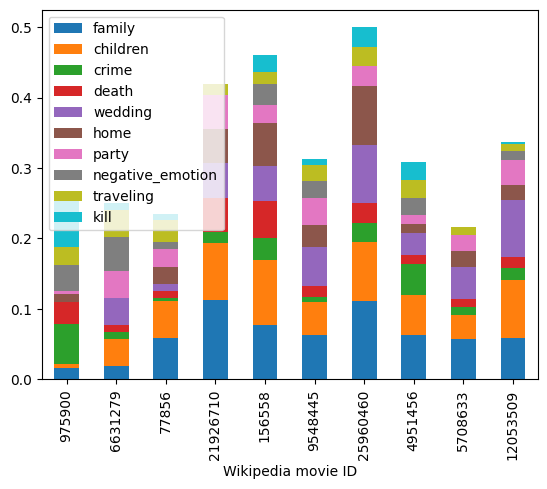

In [24]:
empath_df[top_categories][:10].plot.bar(stacked=True)

In [25]:
# We look at who's more deadly 
top_deadly_movies = empath_df["death"].sort_values(ascending=False).index
top_deadly_movies

Index([27937333, 22348404, 14881706, 19155004,  2372198, 27904601, 10685113,
        6714641,  5747187, 31061078,
       ...
       19374957, 19398864, 17865807,   535453,   364541,  3602322,  6554925,
        3446942,  2239713, 35228177],
      dtype='int64', name='Wikipedia movie ID', length=17077)

<Axes: xlabel='Wikipedia movie ID'>

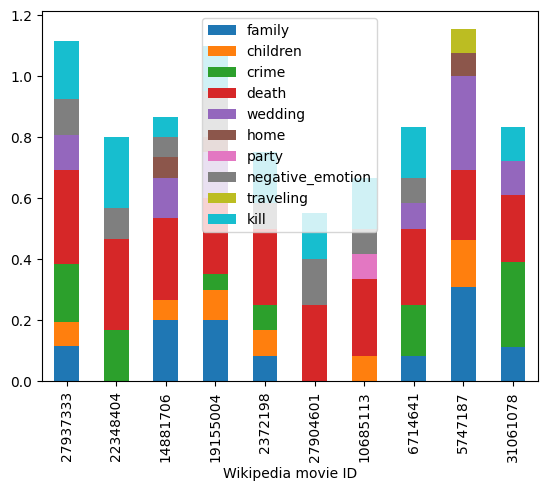

In [26]:
# We look the proportion of deadly in the movies that are classified as most deadly (above) -> still using the same 10 most categories
empath_df.sort_values(by="death", ascending=False)[top_categories][:10].plot.bar(stacked=True)

<Axes: xlabel='Wikipedia movie ID'>

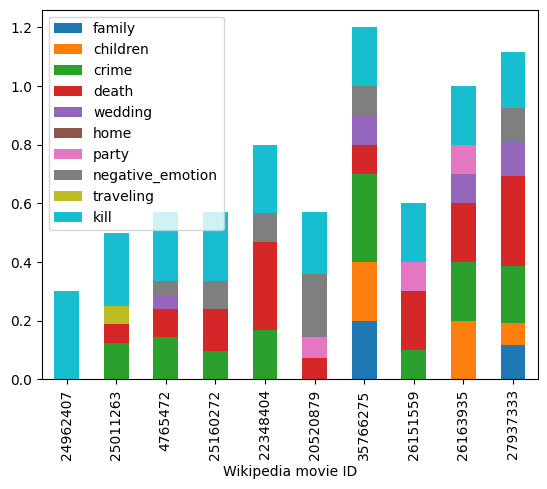

In [27]:
# We do the same but here we use "kill" as category to sort by
empath_df.sort_values(by="kill", ascending=False)[top_categories][:10].plot.bar(stacked=True)

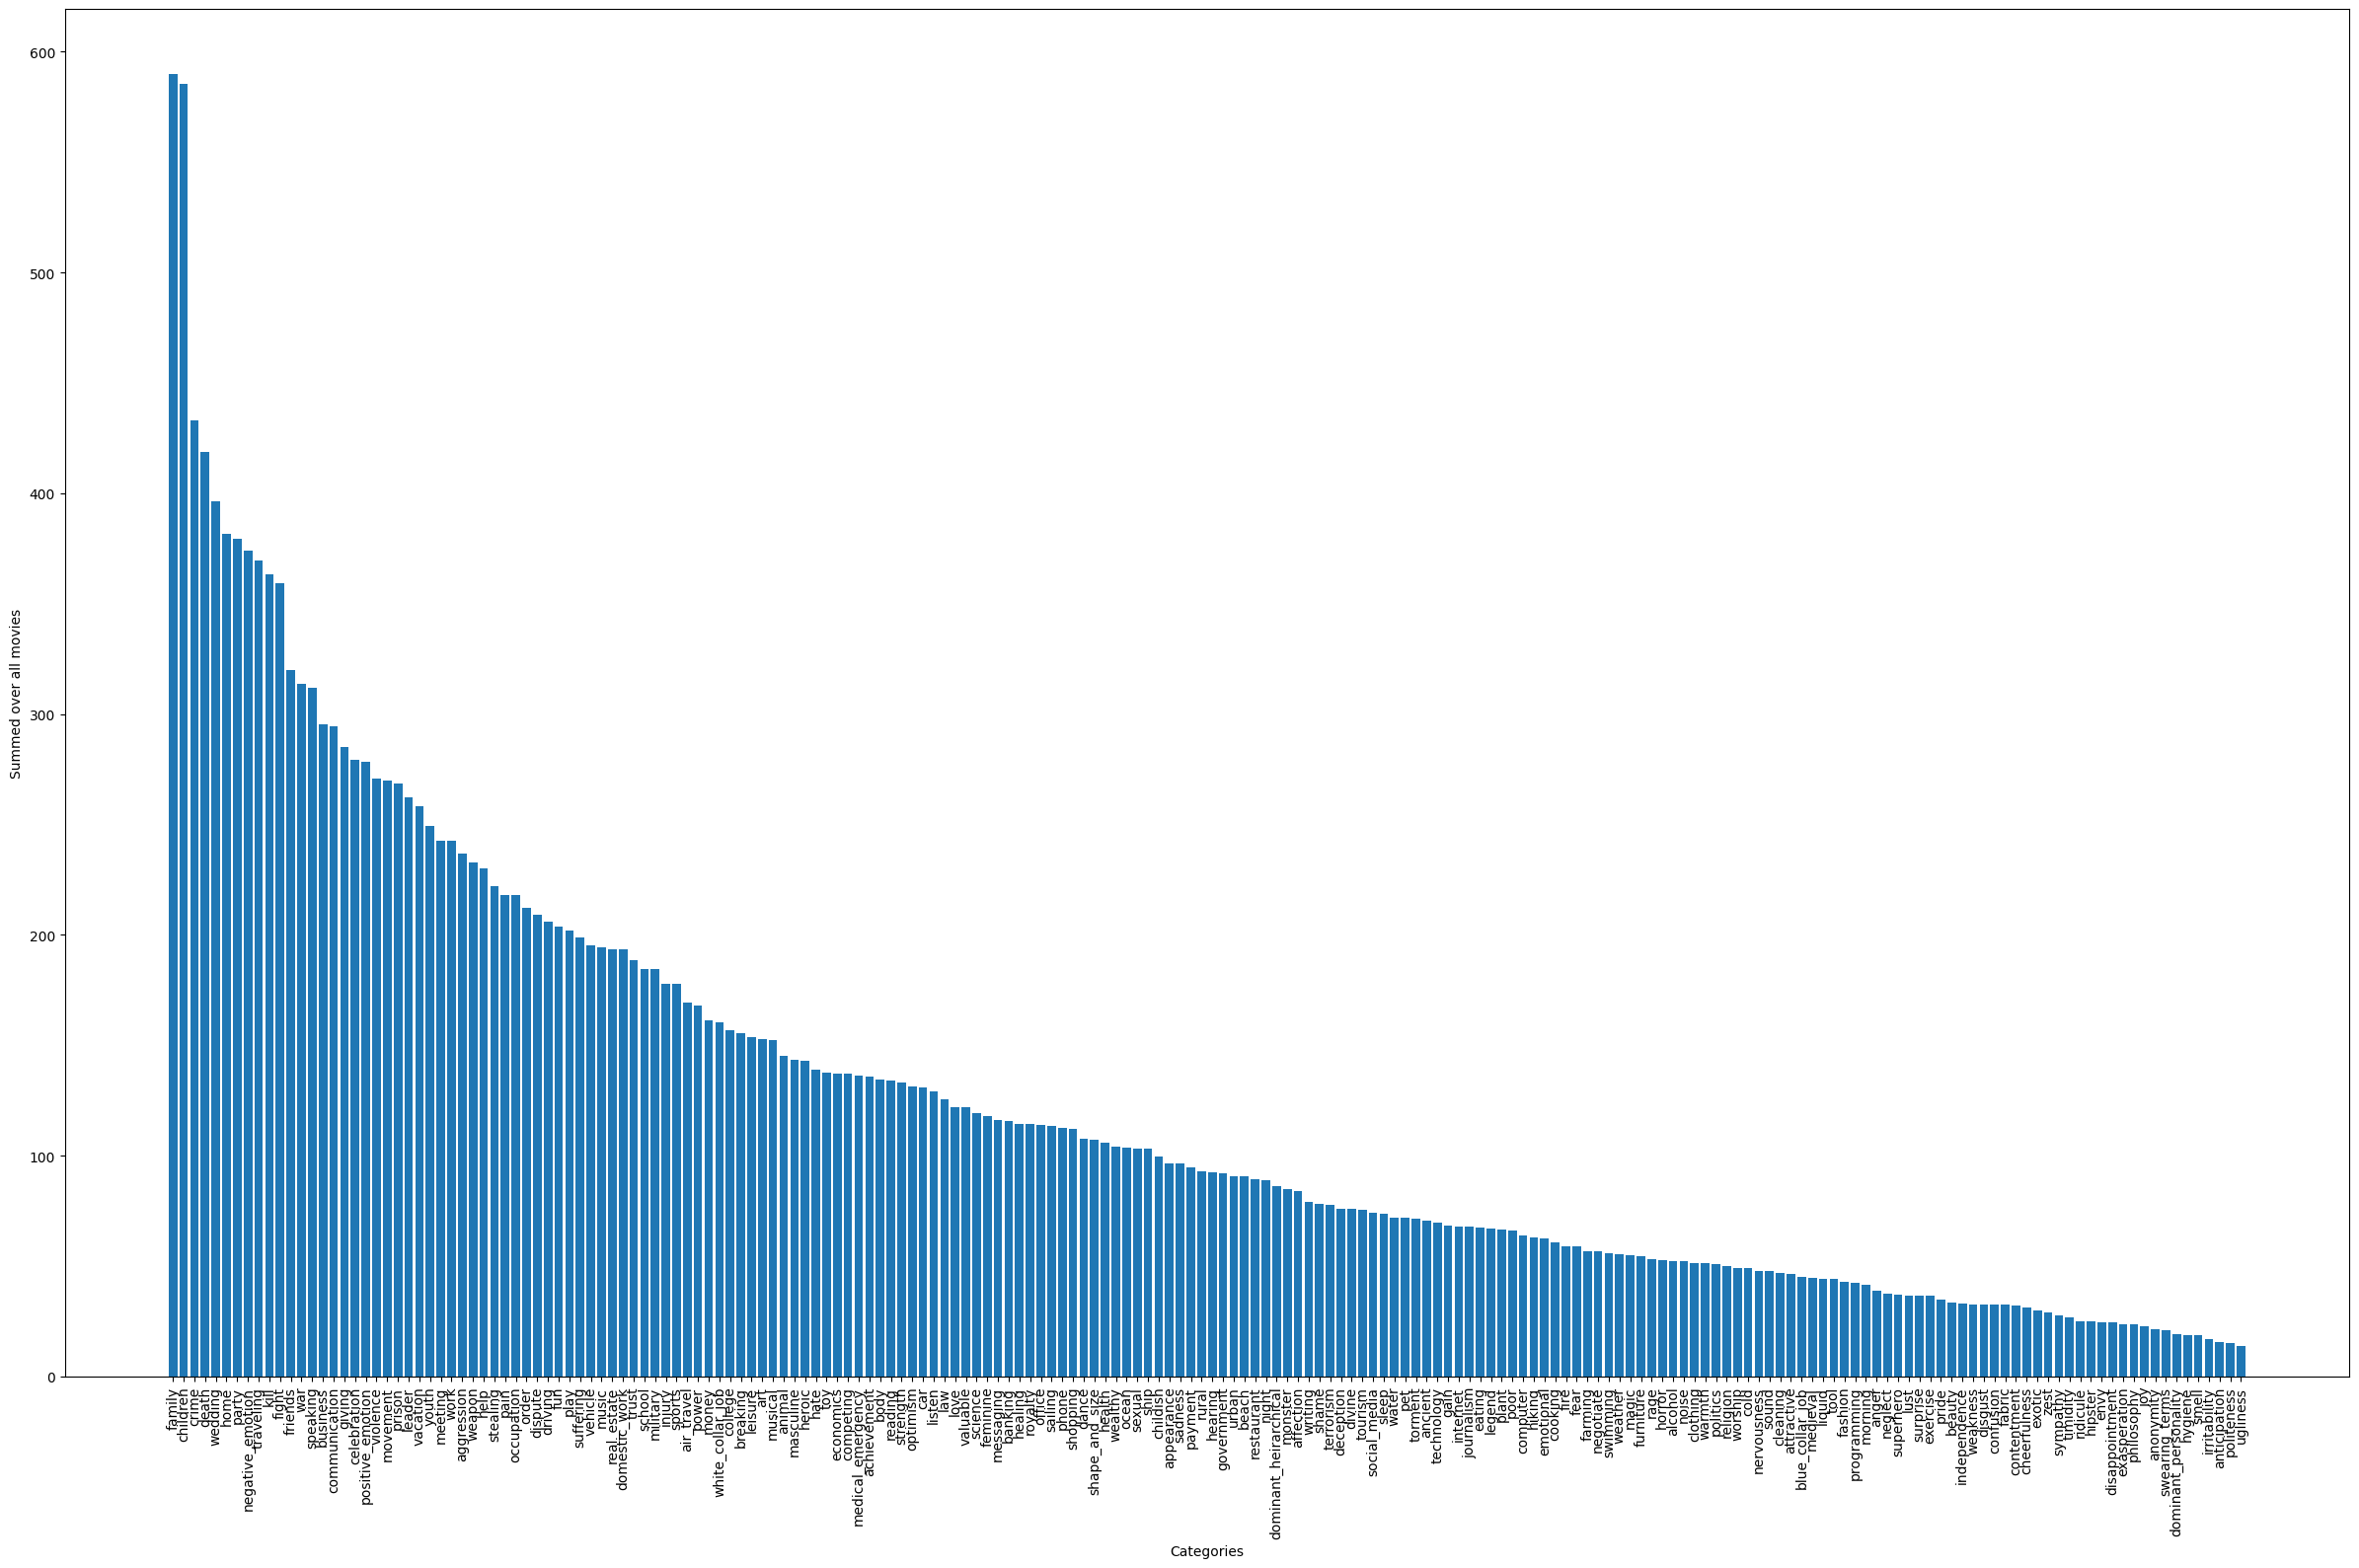

In [28]:
# Histogram for all categories

sorted_categories = empath_df.sum(axis=0).sort_values(ascending=False)

plt.figure(figsize=(24, 16))
plt.bar(sorted_categories.index, sorted_categories.values)
plt.xlabel("Categories")
plt.ylabel("Summed over all movies")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Quest-ce qui ferait du sens? Regarder les movies de Jade et voir si les categories qui ressortent le plus sont coherentes avec la calssification de Chat

<Axes: xlabel='Wikipedia movie ID'>

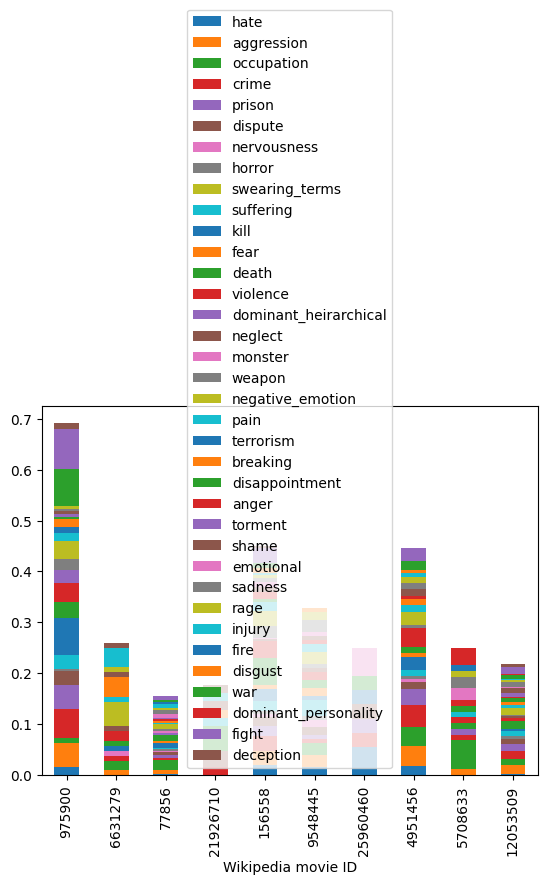

In [34]:
empath_df[violent_categories][:10].plot.bar(stacked=True)


<Axes: >

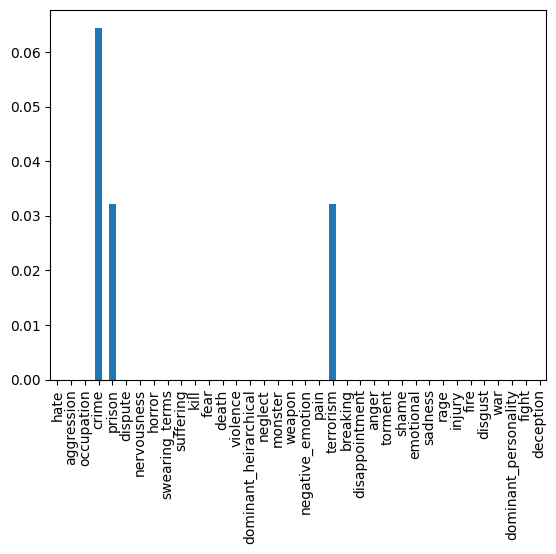

In [36]:
# Let's check for a movie that is known to be violent

empath_df[violent_categories].loc[28074095].plot.bar(stacked=True)

<Axes: >

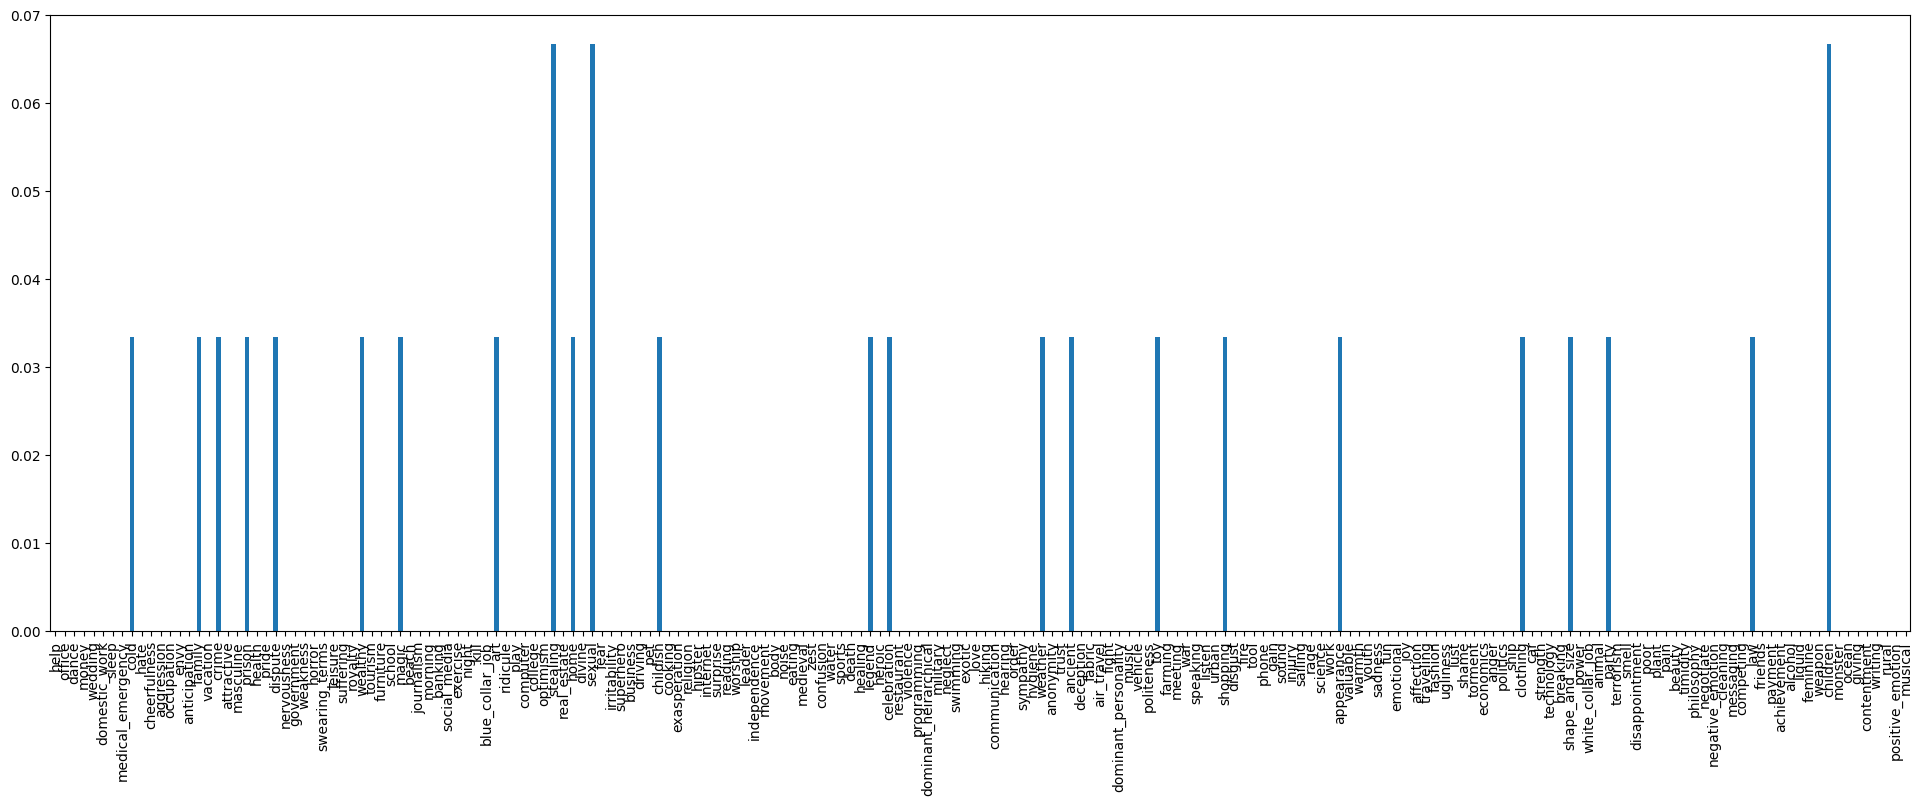

In [40]:
plt.figure(figsize=(24, 8))
empath_df.loc[3477618].plot.bar(stacked=True)

Explained Variance by Component: [0.1057447  0.07456823]


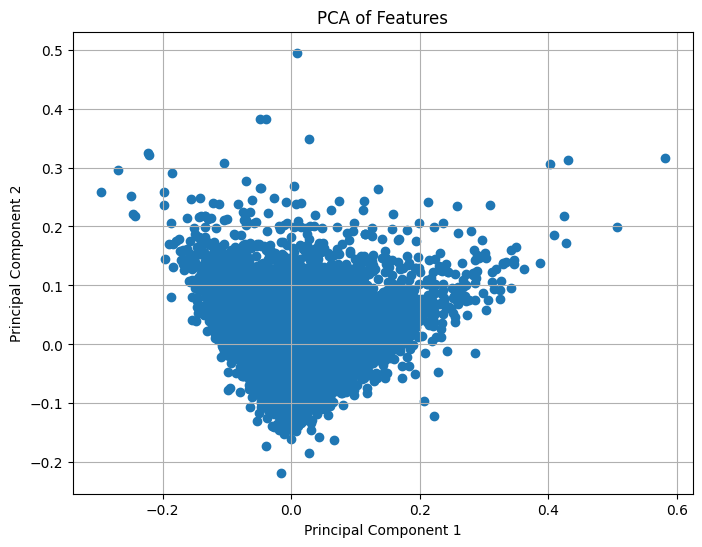

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(empath_df)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(empath_df)

#columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"]

pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])

explained_variance = pca.explained_variance_ratio_
print("Explained Variance by Component:", explained_variance)

plt.figure(figsize=(8, 6))
plt.scatter(pca_df["PC1"], pca_df["PC2"])
plt.title("PCA of Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()